# Bicycel Accidents in Zurich
##### A routing algorithm & *ESC403 Introduction to Data Science* Project
Authors: Dimitri Steiger, Maurus Feyen, Linus Rüegg & Simon Farsky  <br>
Git-Project: https://github.com/thereallinusrg/Velo-Zueri-Unfaelle <br> <br>
In this Notebook we document the **final** pipeline we used to create our routing algorithm. Please have a look at our other notebooks: Linus' Notebook for Segmentation, Weights and Model/Algorithm, Maurus' Notebook for the Normalization Process, and Simon's aswell as DImitri's for EDA and other things we tried.


In [15]:
# All requirements: Dijkstar, pandas, geopandas, shapely, matplotlib, seaborn, folium 
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from dijkstar import Graph, find_path
import folium

In [4]:
# Import Geopackages
VeloWege = gpd.read_file(r'data/Velo_wege.gpkg', crs = "epsg:2056")
Unfaelle = gpd.read_file(r'data/RoadTrafficAccidentLocations.gpkg', crs = "epsg:2056")

# Import CSV
VerkehrsZaehlung = pd.read_csv(r'data/2021_verkehrszaehlungen_werte_fussgaenger_velo.csv')
# Turn it into a GeoDataFrame with point geometries
Zaehlungen = gpd.GeoDataFrame(
    VerkehrsZaehlung, geometry=gpd.points_from_xy(VerkehrsZaehlung.OST, VerkehrsZaehlung.NORD), crs = "epsg:2056")

# EDA
1: First, we will conduct an EDA on all three data-sets to get a feeling for the data


### Counting Stations

<AxesSubplot:>

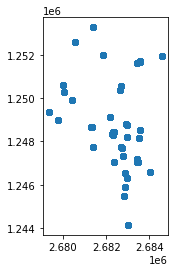

In [5]:
Zaehlungen.plot()

In [6]:
Zaehlungen.head(3)

,FK_ZAEHLER,FK_STANDORT,DATUM,VELO_IN,VELO_OUT,FUSS_IN,FUSS_OUT,OST,NORD,geometry
0,U15G3063865,1357,2021-01-01T00:00,NaN,NaN,20.0,0.0,2682973,1246329,POINT (2682973.000 1246329.000)
1,ECO09113499,3927,2021-01-01T00:00,0.0,3.0,NaN,NaN,2682873,1245891,POINT (2682873.000 1245891.000)
2,U15G3063867,1358,2021-01-01T00:00,NaN,NaN,4.0,1.0,2683557,1251702,POINT (2683557.000 1251702.000)


### Bicycle Network

<AxesSubplot:>

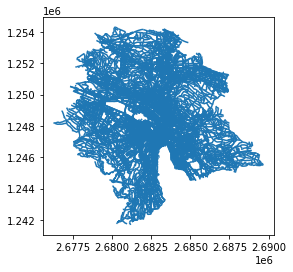

In [7]:
VeloWege.plot()

In [8]:
VeloWege.head(3)

,id1,velo,velostreifen,veloweg,einbahn,fuss,name,map_velo,map_fuss,se_anno_cad_data,objectid,geometry
0,137,0,0,0,0,1,"Bahnhof Oerlikon, Perron Gleis 6",0,0,b'',1.0,"LINESTRING (2683427.088 1251829.395, 2683455.0..."
1,138,0,0,0,0,0,Bahnhofstrasse,0,0,b'',2.0,"LINESTRING (2683164.177 1247919.613, 2683164.9..."
2,139,1,0,0,0,0,Zwischenbächen,1,0,b'',3.0,"LINESTRING (2678697.201 1248708.631, 2678677.6..."


### Accidents

In [9]:
# Filter to only contain Accidents involving Bikes
VeloUnfaelle = Unfaelle.loc[Unfaelle['AccidentInvolvingBicycle']==True]

<AxesSubplot:>

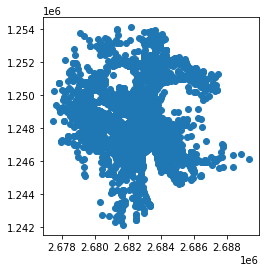

In [10]:
VeloUnfaelle.plot()

In [11]:
VeloUnfaelle.head(3)

,AccidentUID,AccidentType,AccidentType_de,AccidentType_fr,AccidentType_it,AccidentType_en,AccidentSeverityCategory,AccidentSeverityCategory_de,AccidentSeverityCategory_fr,AccidentSeverityCategory_it,...,AccidentMonth_it,AccidentMonth_en,AccidentWeekDay,AccidentWeekDay_de,AccidentWeekDay_fr,AccidentWeekDay_it,AccidentWeekDay_en,AccidentHour,AccidentHour_text,geometry
1,9FD6441F802C20A6E0430A865E3320A6,at0,Schleuder- oder Selbstunfall,dérapage ou perte de maîtrise,Incidente di sbandamento o per colpa propria,Accident with skidding or self-accident,as3,Unfall mit Leichtverletzten,accident avec blessés légers,Incidente con feriti leggeri,...,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,1.0,01h-02h,POINT (2682382.000 1246980.000)
9,9FDA0D984DA49018E0430A865E339018,at8,Fussgängerunfall,accident impliquant des piétons,Incidente con pedoni,Accident involving pedestrian(s),as2,Unfall mit Schwerverletzten,accident avec blessés graves,Incidente con feriti gravi,...,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,15.0,15h-16h,POINT (2683238.000 1246773.000)
19,9FC2F14A65F30050E0430A865E330050,at3,Abbiegeunfall,accident en quittant une route,Incidente nello svoltare,Accident when turning left or right,as3,Unfall mit Leichtverletzten,accident avec blessés légers,Incidente con feriti leggeri,...,Gennaio,January,aw401,Montag,lundi,Lunedí,Monday,8.0,08h-09h,POINT (2681179.000 1247560.000)


(array([  0., 100., 200., 300., 400., 500., 600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

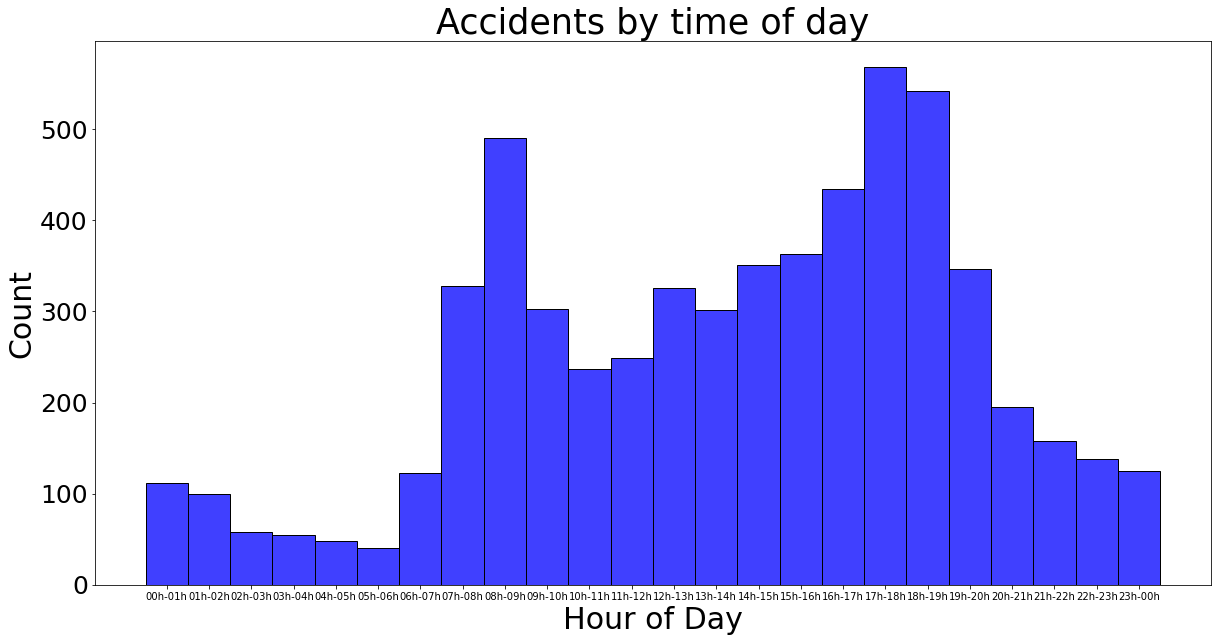

In [16]:
#sort everything by accidenthour for better plotting
unf = Unfaelle[Unfaelle["AccidentInvolvingBicycle"] == True]
unf = unf.sort_values(by = ['AccidentHour_text'])

fig = plt.figure(figsize=(20,10))
sns.histplot(data = unf.AccidentHour_text, color = 'blue')
plt.title('Accidents by time of day',fontsize=35)
plt.xlabel('Hour of Day',fontsize=30)
plt.ylabel('Count',fontsize=30)

plt.yticks(fontsize=25)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

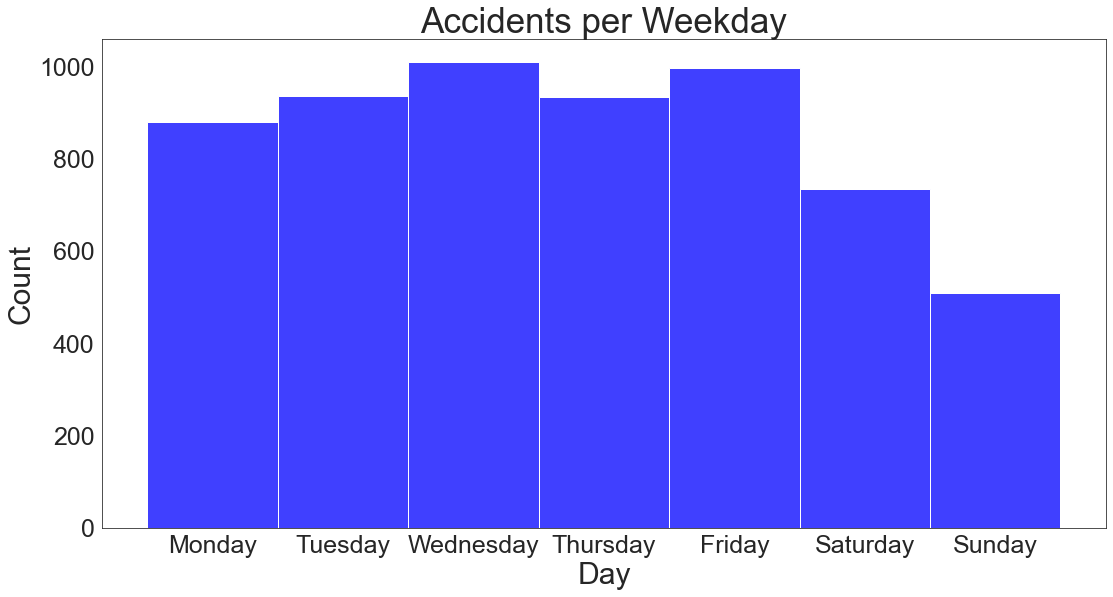

In [17]:
#sort everything by accidentweekday for better plotting
unf = unf.sort_values(by = ['AccidentWeekDay'])

fig = plt.figure(figsize=(18,9))
sns.set_style("white")
sns.histplot(unf.AccidentWeekDay_en,  color = 'blue')
plt.title('Accidents per Weekday',fontsize=35)
plt.xlabel('Day',fontsize=30)
plt.ylabel('Count',fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

(array([  0., 100., 200., 300., 400., 500., 600., 700., 800., 900.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

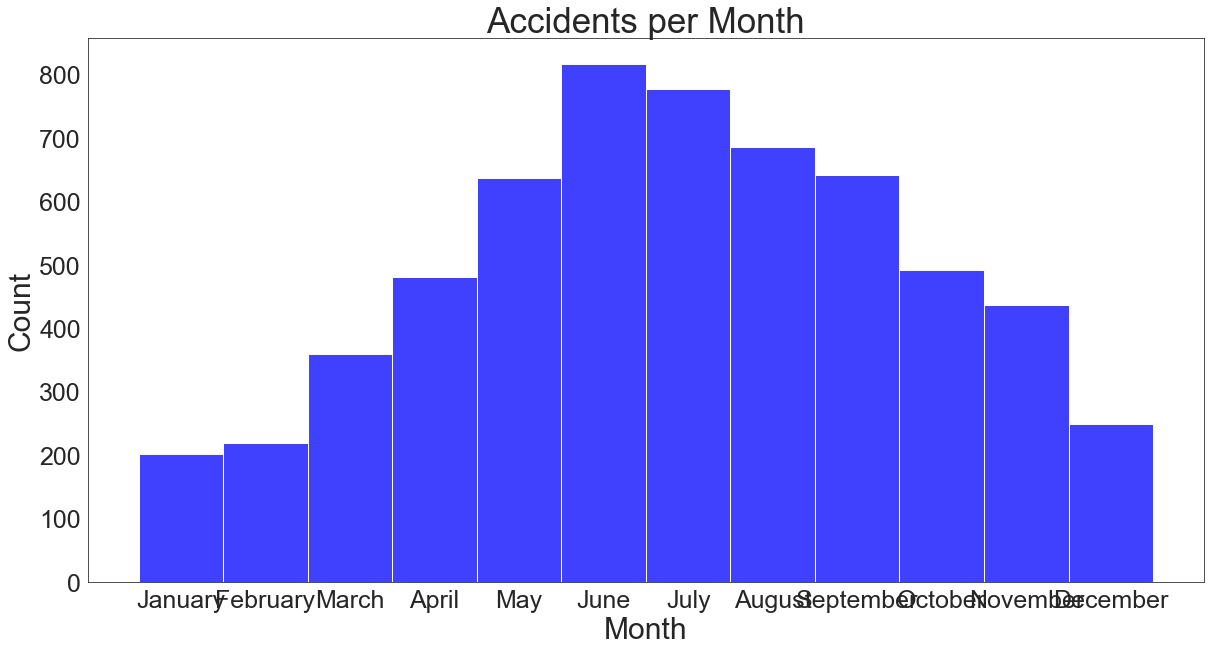

In [18]:
#sort everything by accidentmonth for better plotting
unf = unf.sort_values(by = ['AccidentMonth'])

fig = plt.figure(figsize=(20,10))
sns.histplot(data = unf.AccidentMonth_en, color = 'blue' ,binwidth=0.5)
plt.title('Accidents per Month',fontsize=35)
plt.xlabel('Month',fontsize=30)
plt.ylabel('Count',fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


(array([  0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

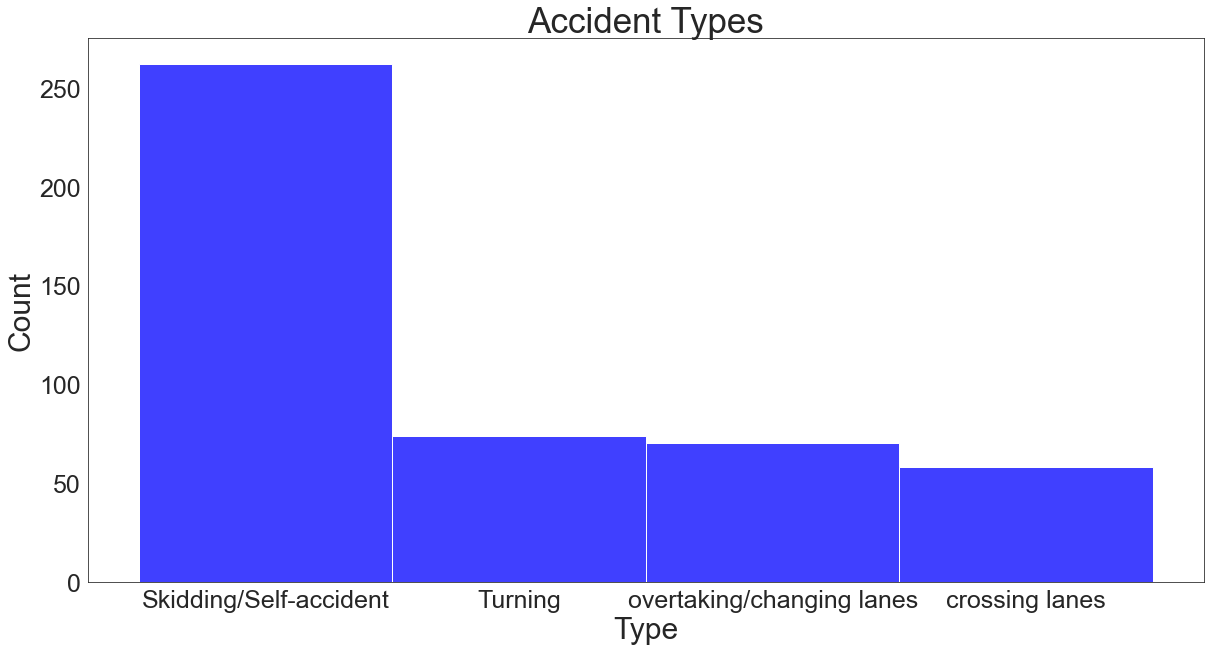

In [19]:
#Which predictor variables are associated the most with bicycle accidents?
acci = pd.read_csv('/Users/simon/Desktop/$Uni Unterlagen/Uzh Skirptz/FS22/EOS403/project/Velo-Zueri-Unfaelle/data/accidentsss.csv', sep = ';')
acci = acci.sort_values(by=['Order'])
fig = plt.figure(figsize=(20,10))
sns.histplot(data = acci.types, color = 'blue' ,binwidth=0.1)
plt.title('Accident Types',fontsize=35)
plt.xlabel('Type',fontsize=30)
plt.ylabel('Count',fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

#### EDA Conclusions
- we have all data in LV95 (epsg:2056)
    - this is good for analysis. if we face problems with visualizing in the end, we can use the following pyproj transformer to project it into WGS84 webmercator
- the Zaehlungen set is quite large (beacause of it's huge time dimension), we need to work smart with it and not do loops on it
- the Unfaelle have to be filtered! To only include the bicycle ones.
- we know which LineStrings are oneway streets.... but all bicyclists are criminals, so that dosen't matter ;)

- Patterns for each temporal resolution can be seen:
    - daily: most accident during rush hour times (7-10 and 17-19 o'clock)
    - weekly: less accidents during the weekends due to less commuting to work
    - monthly: most accidents happen in the summer months as people commute more by bicylcle in the summer months.
 
- Skidding and self-accidents are the most common type of accidents

# Data Preparation
## Segmentation
2: We segment the bicycle path network into nodes and edges
- **Not needed! The path network is already segmented :)**
    - It contains "edges only" - it is split at every node
- Checked the gpkg in QGIS, easy to see
## Attribute Accidents to Edges (Line Segments). 
3:Accidents get also attributed by severity of the accident (categories already set by raw data)<br>
- Goal: gdf with Edges and geographically matched incident attributes
    - We need to think about how this should look like. 
        - Do we need to keep the single accidents? 
        - Should we summarize only geographically and get rid of time? <br>
--> add id1 from VeloWege to accidents<br>
--> See linus-notebook.ipynb for whole thought-process

We used QGIS to split the lines in vertices, as it has a very efficent function for that: <br>
We show the ```QGIS Python code``` for reproducabillity. <br>
<br>
With QGIS:
- Load Lines gpkg
- Vector > Geometry Tools > Extract Vertices
    - ```processing.run("native:extractvertices", {'INPUT':'/home/linusrg/Code/Velo-Zueri/Velo-Zueri-Unfaelle/data/Velo_wege.gpkg|layername=taz_mm_tbl_routennetz|geometrytype=LineString','OUTPUT':'TEMPORARY_OUTPUT'}) ```
- Resulting in a temporary new Point Layer
- Vector > Analysis Tools > Distance Matrix...
    - ```processing.run("qgis:distancematrix", {'INPUT':'/home/linusrg/Code/Velo-Zueri/Velo-Zueri-Unfaelle/data/VeloUnfaelle.gpkg|layername=VeloUnfaelle','INPUT_FIELD':'AccidentUID','TARGET':'memory://memory?geometry=Point&crs=EPSG:2056&field=id:int8(0,0)&field=id1:int8(0,0)&field=velo:integer(0,0)&field=velostreifen:string(5,0)&field=veloweg:integer(0,0)&field=einbahn:string(5,0)&field=fuss:integer(0,0)&field=name:string(150,0)&field=map_velo:integer(0,0)&field=map_fuss:integer(0,0)&field=se_anno_cad_data:binary(0,0)&field=objectid:double(0,0)&field=vertex_index:integer(10,0)&field=vertex_part:integer(10,0)&field=vertex_part_index:integer(10,0)&field=distance:double(20,14)&field=angle:double(20,14)&uid={9918bfc2-204d-4ba5-8029-2cb852b1148f}','TARGET_FIELD':'id1','MATRIX_TYPE':0,'NEAREST_POINTS':1,'OUTPUT':'TEMPORARY_OUTPUT'})```
- We then exported the matrix as csv and import it here again:  

In [10]:
DistMatrix = pd.read_csv("data/DistanceMatrix.csv")

#InputID: VeloUnfaelle['AccidentUID']
#TargetID: VeloWege['id1']
DistMatrix.rename(columns = {'InputID':'AccidentUID', 'TargetID':'id1'}, inplace = True)
DistMatrix.head(3)

,AccidentUID,id1,Distance
0,9FD6441F802C20A6E0430A865E3320A6,1006,8.229085
1,9FDA0D984DA49018E0430A865E339018,3101,4.105777
2,9FC2F14A65F30050E0430A865E330050,6904,1.398630


##### Adding the LineSegment ID to the Accidents

In [11]:
VeloUnfaelle = pd.merge(VeloUnfaelle, DistMatrix, on="AccidentUID", how="inner")

## Weights
Giving the Edges (our LineSegments) a weight

In [12]:
# Creating the time axis
timeAx = sorted(VeloUnfaelle['AccidentHour'].unique())
timeAx = list(map(int, timeAx))
print(timeAx)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [13]:
# Creating the way (LineSegments) Axis
wayAx = sorted(DistMatrix['id1'].unique())
wayAx = list(map(int, wayAx))

In [14]:
# Creating the empty Weights df
Weights = pd.DataFrame(0,
                    columns = timeAx,
                    index = wayAx)

#### The Price of Life, choosing the Weights - This is a hard ethical Question
We have four categories: as1 - somebody died, as2 - someone was heavily injured, as3 - someone was lightly injured, as4 - material damage only. Now we have to weigh those categories numerically. 

In [15]:
# How we price the different accidents
severityDict = {'as1': 100,'as2': 50, 'as3': 20, 'as4':5 }

In [16]:
# We create a new column with our quantitative Values
VeloUnfaelle['SeverityWeight'] = VeloUnfaelle['AccidentSeverityCategory'].map(severityDict)

In [17]:
# Populating the time x way dataframe with weights
for way in wayAx:    
    for time in timeAx:
        Weights.at[way, time] = VeloUnfaelle.loc[(VeloUnfaelle['AccidentHour'] == time) & (VeloUnfaelle['id1'] == way), 'SeverityWeight'].sum()
# Not super elegant, but it only runs for ca 1min.

In [18]:
Weights

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
1,0,0,0,0,20,20,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,20,50,...,0,0,0,0,20,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,20,...,0,0,0,0,0,0,0,0,0,0
21,0,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,20,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47192,0,0,0,0,0,0,0,0,20,0,...,0,0,0,0,0,0,0,0,0,0
47512,0,0,0,0,0,0,0,0,0,0,...,0,20,0,0,0,0,0,0,0,0
47513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47827,0,0,0,0,0,0,0,0,0,0,...,0,0,0,20,0,0,0,0,0,0


## Normalization
4: Then, accidents normalized by the closest (determined via Voronoi tessellation) counting station value. 
The resulting graph of safety-weighted edges has an x, y and t (Lat, Long and Daytime) dimension. <br>
--> Check "maurus-notebook.ipynb" for the detailed steps!


** Maurus' Code here **

<AxesSubplot:>

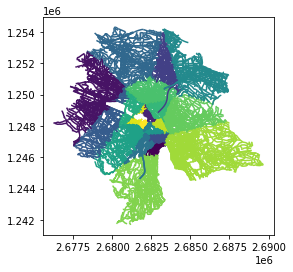

In [19]:
VeloWege_Weights = gpd.read_file(r'data/RadWege_Weight.gpkg')
VeloWege_Weights.plot(column='Weight', cmap='viridis')

These values approximate the total bicycle traffic in the voronoi cells encompassing the counting station where the value was created. We then attribute every LineSegement of the Bicycle Network with the spatially closest counting station. The values are calculated by dividing the total number of bicyclists in the City of Zurich ....

In [20]:
VeloWege_Weights.Weight.unique()

array(['0.067837', '0.00061', '0.026143', '0.017653', '0.073929',
       '0.042095', '0.035435', '0.027373', '0.169791', '0.01289',
       '0.088292', '0.056389', '0.012607', '0.116325', '0.047695',
       '0.046516', '0.025107', '0.054176', '0.015626', '0.025979',
       '0.032641', '0.004892\n', None], dtype=object)

In [21]:
type(VeloWege_Weights.Weight[:1].item())

str

We need to clean this a bit and convert it from strings to floats. Also we need to multiply the values by 100 to get percent (and with that a nicher number to multiply weights with)

In [22]:
corrDict = {'0.004892\n': '0.004892', None : '0.01', '0.067837': '0.067837', '0.00061': '0.00061', '0.026143': '0.026143', '0.017653': '0.017653', '0.073929': '0.073929', '0.042095': '0.042095', '0.035435': '0.035435', '0.027373': '0.027373', '0.169791': '0.169791', '0.01289': '0.01289', '0.088292':'0.088292', '0.056389':'0.056389',  '0.012607':'0.012607', '0.116325': '0.116325', '0.047695':'0.047695', '0.046516': '0.046516', '0.025107': '0.025107', '0.054176': '0.054176', '0.015626': '0.015626', '0.025979': '0.025979', '0.032641': '0.032641'}
VeloWege_Weights.Weight = VeloWege_Weights.Weight.map(corrDict)
VeloWege_Weights.Weight.unique()

array(['0.067837', '0.00061', '0.026143', '0.017653', '0.073929',
       '0.042095', '0.035435', '0.027373', '0.169791', '0.01289',
       '0.088292', '0.056389', '0.012607', '0.116325', '0.047695',
       '0.046516', '0.025107', '0.054176', '0.015626', '0.025979',
       '0.032641', '0.004892', '0.01'], dtype=object)

In [23]:
VeloWege_Weights.Weight = VeloWege_Weights.Weight.astype(float)*100
VeloWege = VeloWege_Weights
VeloWege.Weight.unique()

array([ 6.7837,  0.061 ,  2.6143,  1.7653,  7.3929,  4.2095,  3.5435,
        2.7373, 16.9791,  1.289 ,  8.8292,  5.6389,  1.2607, 11.6325,
        4.7695,  4.6516,  2.5107,  5.4176,  1.5626,  2.5979,  3.2641,
        0.4892,  1.    ])

In [24]:
# We drop duplicates, that occured because of unclean street to voronoi cell attribution (overlaying voronoi cells)
VeloWege = VeloWege.drop_duplicates(subset=['id1'])

We will multiply this in, when we populate our graph.

# Model (Graph & Algorithm)

5: We will then use this graph to train a model (Maybe SVM, GCN or we will see what the lecture brings us).
The model should then be capable to predict the safety of any rout at any time in Zurich <br>
--> Well, we do not need a model to do that, we need an algorithm :)<br>
<br>
We choose Dijkstra's ALgorithm to find the shortest path in a Graph. We first imlpemented it ourselfs (see linus-notebook.ipynb). But for performance & functionallity reseons we then switched to a library. 

### Building the Graph
So we need nodes (the start and end points). We need to create them from our VeloWege gdf:

In [25]:
# Create a new column with start an endpoint as a MultiPoint object
VeloWege['boundary'] = VeloWege.geometry.boundary

/home/linusrg/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


To make linestrings connect, we will get rid of the decimals and the last two cartesian cordiante digit (so we can connect segemnts in the same 100 meters square) --> we need this to connect street segments, since the topology was not great in all places. (Would fix topology next time first, before starting the coding)

In [26]:
def shortLV95(coords):
    east = coords.split(" ")[0][:5]
    north = coords.split(" ")[1][:5]
    return f"{east}-{north}"

def getVerticesSlicer(wkt, position = "First"):
    string = str(wkt)
    if len(string) < 40:
        return "nein", "nein"
    elif position == "Last":
        list = string.split(", ")
        last = list[1].split(")")[0]
        last = shortLV95(last)
        return str(last)
    else:
        list = string.split(", ")
        first = list[0].split("(")[1]
        first = shortLV95(first)
        return str(first)

def cost_func(u, v, edge, prev_edge):
    length, name = edge
    if prev_edge:
        prev_name = prev_edge[1]
    else:
        prev_name = None
    cost = length
    if name != prev_name:
         cost += 1 # Here we add our Basis Risk 
    return cost

### Function to inizalize Graph, run Dijkstar Algorithm and produce a Map

In [27]:
def SafetyFirst(start, destination, time):
    GrafVoZueri = Graph()
    #Add Edges
    for idx, row in Weights.iterrows():
        weight = Weights.loc[idx, time]
        first = VeloWege.loc[VeloWege['id1'] == idx, 'first'].item()
        last = VeloWege.loc[VeloWege['id1'] == idx, 'last'].item()
        routeweight = VeloWege.loc[VeloWege['id1'] == idx, 'Weight'].item()
        GrafVoZueri.add_edge(str(first), str(last), (int(weight)*routeweight, idx))
        GrafVoZueri.add_edge(str(last), str(first), (int(weight)*routeweight, idx))

    route = find_path(GrafVoZueri, start, destination, cost_func=cost_func)
    print(route)

    # Create a GeoDataFrame with the LineSegment Geometries
    geo_list = []
    for edge in route.edges:
        geom = VeloWege.loc[VeloWege['id1'] == edge[1], 'geometry'][:1].item()
        geo_list.append(geom)

    route = gpd.GeoDataFrame(zip(geo_list, route.costs), columns =['geometry', 'weight'], crs="epsg:2056")

    # Convert route gdf from LV95 to WGS84
    georoute = route.to_crs(crs='EPSG:4326')

    # Create Map

    m = folium.Map(location=[47.38397, 8.53080], zoom_start=14, tiles='CartoDB positron')

    for _, r in georoute.iterrows():
        r['weight'] # for color
        sim_geo = gpd.GeoSeries(r['geometry']) #.simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j)

        geo_j.add_to(m)
    return m

In [30]:
# create empty columns for the nodes (first and last)
VeloWege['last'] = ""
VeloWege['first'] = ""

# apply function
VeloWege['last'] = VeloWege.apply(lambda row : getVerticesSlicer(row['boundary'].wkt, position = "Last"), axis = 1)
VeloWege['first'] = VeloWege.apply(lambda row : getVerticesSlicer(row['boundary'].wkt), axis = 1)

# Our unique nodes
nodes = pd.concat([VeloWege['last'], VeloWege['first']], axis = 0).unique()

/home/linusrg/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/home/linusrg/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/home/linusrg/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

##### Use the Model
Choose a predefined (defintly working) example or use the randomize to connect two random nodes in Zurich. Some might throw an error, as dijkstar might not always find a path.<br>
- start: To five digits shortend epsg:2056 coordinate of the start node. (string)
- sestination: To five digits shortend epsg:2056 coordinate of the desired destination node. (string)
- time: hour of the day (0-23), for which the route should be calculated (int)

In [29]:
VeloWege

,id,id1,velo,velostreifen,veloweg,einbahn,fuss,name,map_velo,map_fuss,se_anno_cad_data,objectid,Weight,geometry,boundary
0,7534,4832,1,0,0,0,1,Risweg,0,0,b'',7556.0,6.7837,"LINESTRING (2680608.456 1241937.390, 2680579.5...","MULTIPOINT (2680608.456 1241937.390, 2680315.5..."
1,7983,5491,1,0,0,0,1,Fussweg,0,0,b'',8011.0,6.7837,"LINESTRING (2680608.456 1241937.390, 2680590.5...","MULTIPOINT (2680608.456 1241937.390, 2680722.5..."
2,17606,18931,1,0,0,0,1,Fussweg,0,0,b'',17680.0,6.7837,"LINESTRING (2680640.530 1241963.451, 2680650.4...","MULTIPOINT (2680640.530 1241963.451, 2680655.3..."
3,19737,18449,1,0,0,0,1,Fussweg,0,0,b'',19824.0,6.7837,"LINESTRING (2680655.387 1241931.557, 2680673.2...","MULTIPOINT (2680655.387 1241931.557, 2680956.6..."
4,3839,3852,1,0,0,0,1,Fussweg,0,1,b'',3848.0,6.7837,"LINESTRING (2680663.388 1242134.614, 2680663.0...","MULTIPOINT (2680663.388 1242134.614, 2680722.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41275,30382,32105,1,0,0,0,1,Verbindung Fussweg,0,0,b'',30512.0,1.0000,"LINESTRING (2685655.225 1252378.378, 2685646.1...","MULTIPOINT (2685655.225 1252378.378, 2685646.1..."
41276,31303,29163,1,0,1,0,1,Glattparkstrasse Opfikon,1,0,b'',31433.0,1.0000,"LINESTRING (2684729.887 1252515.828, 2684756.3...","MULTIPOINT (2684729.887 1252515.828, 2684756.3..."
41277,34624,35840,1,0,0,0,1,Stettbachstrasse,1,0,b'',34767.0,1.0000,"LINESTRING (2686794.286 1250076.960, 2686814.9...","MULTIPOINT (2686794.286 1250076.960, 2686910.8..."
41278,34869,35905,0,0,0,0,1,Bootssteg,0,0,b'',35017.0,1.0000,"LINESTRING (2682955.442 1246121.273, 2682936.5...","MULTIPOINT (2682955.442 1246121.273, 2682936.5..."


In [31]:
start = '26847-12462'
destination = '26818-12496'

#start = '26828-12457'
#destination = '26818-12496'

#start = '26837-12510'
#destination = '26818-12496'

#start = '26826-12501'
#destination = '26818-12496'

#start = '26850-12513'
#destination = '26818-12496'

import random
#start = nodes[random.randint(1, len(nodes))]
#destination = nodes[random.randint(1, len(nodes))]

time = 16

SafetyFirst(start, destination, time)

PathInfo(nodes=['26847-12462', '26846-12463', '26845-12463', '26846-12464', '26845-12465', '26844-12467', '26843-12469', '26844-12469', '26844-12470', '26843-12470', '26842-12471', '26841-12471', '26840-12471', '26839-12472', '26838-12472', '26837-12473', '26837-12474', '26837-12475', '26836-12476', '26835-12479', '26835-12481', '26834-12481', '26834-12480', '26833-12481', '26832-12480', '26832-12481', '26830-12481', '26829-12482', '26830-12482', '26830-12483', '26830-12484', '26829-12485', '26827-12487', '26825-12489', '26823-12491', '26821-12492', '26820-12494', '26818-12495', '26819-12495', '26819-12496', '26818-12496'], edges=[(0.0, 23212), (0.0, 15004), (0.0, 35427), (0.0, 26627), (0.0, 29313), (0.0, 8512), (0.0, 16087), (0.0, 29440), (0.0, 31357), (0.0, 38918), (0.0, 37949), (0.0, 24894), (0.0, 29628), (0.0, 14144), (0.0, 39018), (0.0, 28208), (0.0, 19134), (0.0, 28842), (0.0, 7105), (0.0, 22498), (0.0, 36093), (0.0, 15445), (0.0, 5197), (0.0, 23344), (0.0, 24054), (0.0, 16148), 

### How to improve this result:
- Use a topology checked/fixed Bicycle Network, to be able to use higher precission Nodes coordinates, so no gaps are presented in the route.
- Use a ML model to fill the weights for more times & LineSegments
- Do a temporal finer data setup (e.g.: a weight chart for each day)